In [1]:
import ridge_classifier as ridc 
import numpy as np
import pandas as pd
import scipy.io as sio
import plotting
import os
import utils
import ABIDEParser as Reader
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, GridSearchCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Ridge, LogisticRegression
import sklearn
from sklearn import svm, datasets
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import ridge_classifier as rclass

## RidgeClassifier with PCA analysis

500.0
230


C:\Users\33781\AppData\Local\Temp\ipykernel_27960\724152176.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w*" (-> color='w'). The keyword argument will take precedence.
  plt.plot(max_alpha, max_C, 'w*', markersize=15, c='red', label=f'max accuracy: {max_accuracy:.3f}')


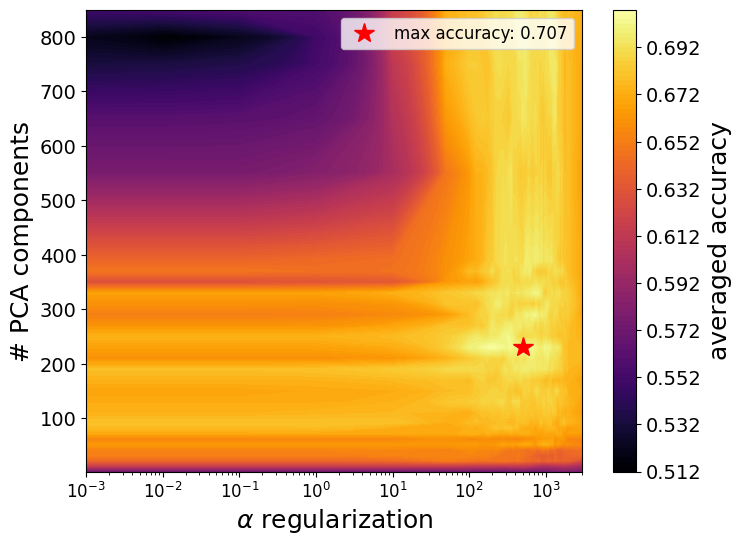

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results/linearRegression/df_ridge_PCA_sensitivity.csv')
df.drop(axis=1, labels="Unnamed: 0", inplace=True)

# Pivot the DataFrame
pivot_df = df.pivot(index='PCA_nb_components', columns='alpha', values='accuracy_mean')

# Extract grid values
alpha_unique = pivot_df.columns.values  # Columns represent unique alpha values
C_unique = pivot_df.index.values        # Rows represent unique C values
accuracy_grid = pivot_df.values         # Accuracy grid (2D array)

# Find the maximum accuracy and its position
max_idx = np.unravel_index(np.argmax(accuracy_grid, axis=None), accuracy_grid.shape)
max_accuracy = accuracy_grid[max_idx]
max_alpha = alpha_unique[max_idx[1]]
max_C = C_unique[max_idx[0]]

# Create a contour plot
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(alpha_unique, C_unique)  # Create a meshgrid for alpha and C
contour = plt.contourf(X, Y, accuracy_grid, levels=100, cmap='inferno')

# Add the maximum point marker
print(max_alpha)
print(max_C)
plt.plot(max_alpha, max_C, 'w*', markersize=15, c='red', label=f'max accuracy: {max_accuracy:.3f}')

# Set logarithmic scale for alpha
plt.xscale('log')
# plt.yscale('log')

# Add labels, colorbar, legend, and title
plt.colorbar(contour, label='averaged accuracy')
plt.xlabel(r'$\alpha$ regularization')
plt.ylabel('# PCA components')
plt.legend(loc='best', frameon=True)
plt.savefig('figures/ridge_PCA_sensitivity_analysis.png', dpi=250)
plt.savefig('figures/ridge_PCA_sensitivity_analysis.pdf', dpi=250)


## RidgeClassifier with RFE selection of features

6000
500.0
0.6464602925809824


C:\Users\33781\AppData\Local\Temp\ipykernel_27960\3298972287.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ws" (-> color='w'). The keyword argument will take precedence.
  plt.plot([1.], [2000], 'ws', markersize=15, c='green', label=f"Ridge accuracy from Parisot's paper: {parisot_accuracy:.3f}")


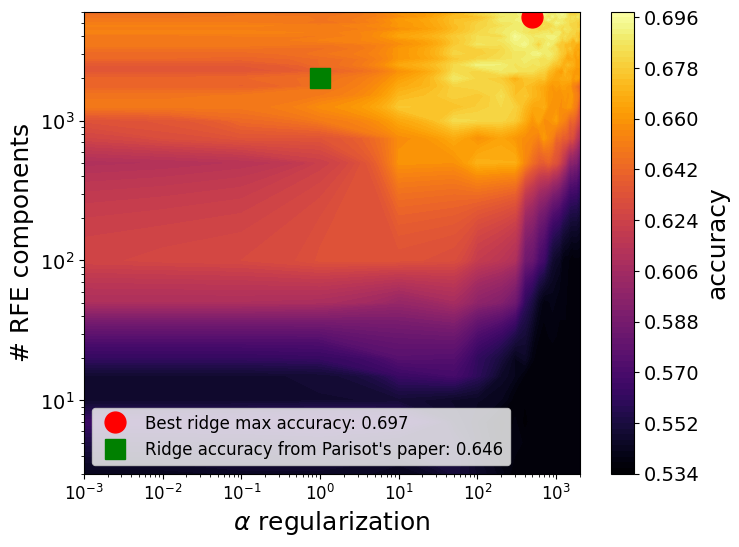

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results/linearRegression/df_ridge_RFE_sensitivity.csv')
df.drop(axis=1, labels="Unnamed: 0", inplace=True)

# Pivot the DataFrame
pivot_df = df.pivot(index='RFE_nb_components', columns='alpha', values='accuracy_mean')

# Extract grid values
alpha_unique = pivot_df.columns.values  # Columns represent unique alpha values
C_unique = pivot_df.index.values        # Rows represent unique C values
accuracy_grid = pivot_df.values         # Accuracy grid (2D array)

# Find the maximum accuracy and its position
max_idx = np.unravel_index(np.argmax(accuracy_grid, axis=None), accuracy_grid.shape)
max_accuracy = accuracy_grid[max_idx]
max_alpha = alpha_unique[max_idx[1]]
max_C = C_unique[max_idx[0]]
print(max_C)
print(max_alpha)

# Create a contour plot
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(alpha_unique, C_unique)  # Create a meshgrid for alpha and C
contour = plt.contourf(X, Y, accuracy_grid, levels=100, cmap='inferno')

# Add the maximum point marker
plt.plot(max_alpha, max_C-0.5*10**3, 'o', markersize=15, c='red', label=f'Best ridge max accuracy: {max_accuracy:.3f}')
# Add Parisot point
parisot_accuracy = df[(df["alpha"] == 1.) & (df["RFE_nb_components"] == 2000)]["accuracy_mean"].item()
print(parisot_accuracy)
# plt.plot([1.], [2000], 'w*', markersize=15, c='blue', label=f"paper's accuracy: {parisot_accuracy:.3f}")
plt.plot([1.], [2000], 'ws', markersize=15, c='green', label=f"Ridge accuracy from Parisot's paper: {parisot_accuracy:.3f}")

# Set logarithmic scale for alpha
plt.xscale('log')
plt.yscale('log')

# Add labels, colorbar, legend, and title
plt.colorbar(contour, label='accuracy')
plt.xlabel(r'$\alpha$ regularization')
plt.ylabel('# RFE components')
plt.legend(loc='lower left', frameon=True)
plt.savefig('figures/ridge_RFE_sensitivity_analysis.png', dpi=250)
plt.savefig('figures/ridge_RFE_sensitivity_analysis.pdf', dpi=500)



## Study of regularization of the Ridge Classifier model
Question: why 150 components are needed to get the best accuracy of the model?

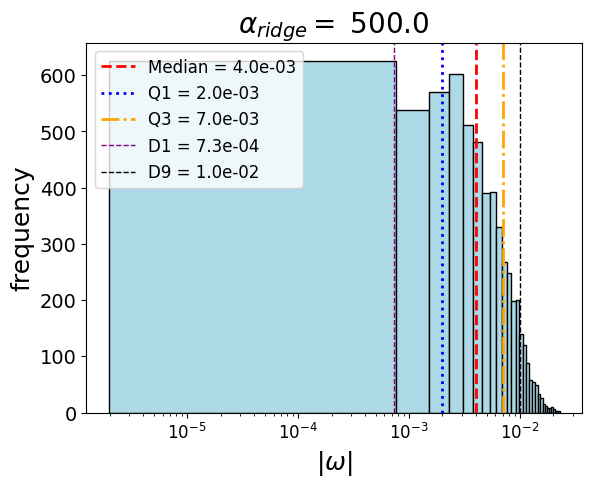

In [12]:
x_data, y, num_nodes = rclass.get_x_data()
skf = StratifiedKFold(n_splits=10)
cv_splits = list(skf.split(x_data, np.squeeze(y)))
train_ind = cv_splits[0][0]
test_ind = cv_splits[0][1]

# x_data = rclass.apply_PCA_on_features(230, x_data)
x_data = rclass.feature_selection(x_data, y, train_ind, 6000)


alpha = 500.
clf = RidgeClassifier(alpha=alpha)
clf.fit(x_data[train_ind, :], y[train_ind].ravel())
# Compute the accuracy
lin_acc = clf.score(x_data[test_ind, :], y[test_ind].ravel())

# Compute the AUC
pred = clf.decision_function(x_data[test_ind, :])
coefs_ridge = clf.coef_.squeeze()


# Exemple de données à afficher
data = np.abs(coefs_ridge)

# Création de l'histogramme
plt.hist(data, bins=30, color='lightblue', edgecolor='black')

# Ajout des titres et des labels
plt.xlabel('$|\omega|$')
plt.ylabel('frequency')
plt.xscale('log')

# Calcul des statistiques
median_value = np.median(data)
q1 = np.percentile(data, 25)  # Premier quartile (Q1)
q3 = np.percentile(data, 75)  # Troisième quartile (Q3)
deciles = [np.percentile(data, i * 10) for i in range(1, 10)]  # Déciles de D1 à D9

# Tracé de la ligne rouge pour la médiane sur l'axe x (log)
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median = {median_value:.1e}')

# Tracé des lignes pour Q1 et Q3 en couleur différente (par exemple, bleu pour Q1 et orange pour Q3)
plt.axvline(q1, color='blue', linestyle=':', linewidth=2, label=f'Q1 = {q1:.1e}')
plt.axvline(q3, color='orange', linestyle='-.', linewidth=2, label=f'Q3 = {q3:.1e}')

colors = ['purple', 'brown', 'pink', 'cyan', 'lime', 'magenta', 'yellow', 'grey', 'black']
for i, d in enumerate(deciles):
    if (i ==0) or (i==8):   
        plt.axvline(d, color=colors[i], linestyle='--', linewidth=1, label=f'D{i+1} = {d:.1e}')

# Affichage de l'histogramme
plt.legend()
plt.title(r"$\alpha_{ridge} = $"+ f" {alpha}")
plt.savefig(f'figures/repartition_coef_ridge_for_alpha_{alpha}.png', dpi = 250)
plt.savefig(f'figures/repartition_coef_ridge_for_alpha_{alpha}.pdf', dpi = 250)



C:\Users\33781\AppData\Local\Temp\ipykernel_4332\851760415.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w*" (-> color='w'). The keyword argument will take precedence.
  plt.plot(max_alpha, max_accuracy, 'w*', markersize=15, c='red', label=f'max accuracy: {max_accuracy:.3f}')


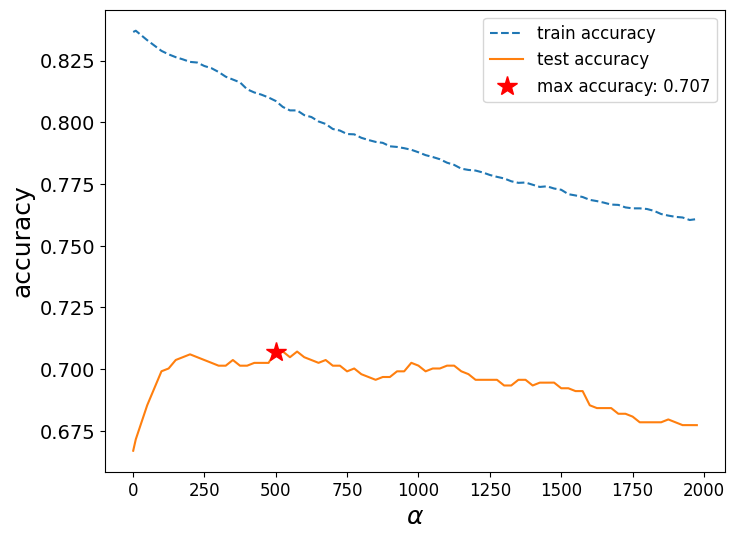

In [157]:
x_data, y, num_nodes = rclass.get_x_data()
x_data = rclass.apply_PCA_on_features(230, x_data)

df = pd.read_csv('results/linearRegression/df_ridge_PCA_sensitivity.csv')
df.drop(axis=1, labels="Unnamed: 0", inplace=True)

# Pivot the DataFrame
pivot_df = df.pivot(index='PCA_nb_components', columns='alpha', values='accuracy_mean')
alpha_unique = pivot_df.columns.values  # Columns represent unique alpha values
test_accuracy_array = df.loc[(df['alpha'] <= 2000.) & (df['alpha'] >= 1.) & (df['PCA_nb_components'] ==230), 'accuracy_mean'].to_numpy()

alphas = alpha_unique[(alpha_unique >=1.) & (alpha_unique <=2000.) ]#2*np.logspace(-3, 3, 100) #[1., 100., 200., 300., 400., 500., 600., 700., 800.]
train_accuracy_list = []

for alpha in alphas:
    train_accuracy_for_alpha = []
    test_accuracy_for_alpha = []
    skf = StratifiedKFold(n_splits=10)
    for train_ind, test_ind in reversed(list(skf.split(np.zeros(num_nodes), np.squeeze(y)))):
        clf = RidgeClassifier(alpha=alpha)
        clf.fit(x_data[train_ind, :], y[train_ind].ravel())
        train_accuracy_for_alpha.append(clf.score(x_data[train_ind, :], y[train_ind].ravel()))
        test_accuracy_for_alpha.append(clf.score(x_data[test_ind, :], y[test_ind].ravel()))
    train_accuracy_list.append(np.mean(np.array(train_accuracy_for_alpha)))
    

plt.figure(figsize=(8, 6))
plt.plot(alphas, train_accuracy_list, label='train accuracy', linestyle='--')
plt.plot(alphas, test_accuracy_array, label='test accuracy')
plt.xlabel(r"$\alpha$")
plt.ylabel('accuracy')

max_idx = np.unravel_index(np.argmax(accuracy_grid, axis=None), accuracy_grid.shape)
max_accuracy = accuracy_grid[max_idx]
max_alpha = alpha_unique[max_idx[1]]
plt.plot(max_alpha, max_accuracy, 'w*', markersize=15, c='red', label=f'max accuracy: {max_accuracy:.3f}')
plt.legend()
plt.savefig('figures/train_and_test_accuracy_ridge_overfitting.png', dpi = 250)
plt.savefig('figures/train_and_test_accuracy_ridge_overfitting.pdf', dpi = 250)



## OLD VERSION

In [ ]:
# def get_networks(subject_list,  kind="correlation", atlas_name="aal", variable="connectivity"):
#     """
#         subject_list : list of subject IDs
#         kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
#         atlas_name   : name of the parcellation atlas used
#         variable     : variable name in the .mat file that has been used to save the precomputed networks


#     return:
#         matrix      : feature matrix of connectivity networks (num_subjects x network_size)
#     """
#     all_networks = []
#     for subject in subject_list:
#         fl = os.path.join(
#             Reader.data_folder, subject, subject + "_" + atlas_name + "_" + kind + ".mat"
#         )
#         matrix = sio.loadmat(fl)[variable]
        
#         all_networks.append(matrix)
#     all_networks=np.array(all_networks)
    
#     idx = np.triu_indices_from(all_networks[0], 1)
#     norm_networks = np.arctanh(all_networks) 
#     vec_networks = [mat[idx] for mat in norm_networks]
#     matrix = np.vstack(vec_networks)
#     return matrix

# def apply_PCA_on_features(n_components, x_data):
#     pca = PCA(n_components=n_components)
#     matrix = pca.fit_transform(matrix)    
#     # print(pca.explained_variance_)
#     return matrix

# def feature_selection(matrix, labels, train_ind, fnum):
#     estimator = RidgeClassifier()
#     selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=0)
#     featureX = matrix[train_ind, :]
#     featureY = labels[train_ind]
#     selector = selector.fit(featureX, featureY.ravel())
#     x_data = selector.transform(matrix)
#     return x_data

In [ ]:
# def get_x_data():
#     acc_res = []
#     subject_IDs = Reader.get_ids()
#     x_data = get_networks(subject_IDs, kind="correlation", atlas_name="ho", variable="connectivity")

#     num_classes = 2
#     num_nodes = len(subject_IDs)
#     labels = Reader.get_subject_score(subject_IDs, score="DX_GROUP")

#     # Initialise variables for class labels and acquisition site
#     y_data = np.zeros([num_nodes, num_classes])
#     y = np.zeros([num_nodes, 1])
#     # x_data = feature_selection(x_data, y, train_ind, 2000)
#     # Get acquisition site
#     site = Reader.get_subject_score(subject_IDs, score="SITE_ID")
#     unique = np.unique(list(site.values())).tolist()
    
#     # G et class labels and acquisition site for all subjects
#     for i in range(num_nodes):
#         y_data[i, int(labels[subject_IDs[i]]) - 1] = 1
#         y[i] = int(labels[subject_IDs[i]])
#         site[i] = unique.index(site[subject_IDs[i]])
        
#     return x_data, y, num_nodes

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# # Generate a synthetic regression dataset
# X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_components = 10
acc_res = []
subject_IDs = Reader.get_ids()
x_data = get_networks(n_components, subject_IDs, kind="correlation", atlas_name="ho", variable="connectivity")


num_classes = 2
num_nodes = len(subject_IDs)
labels = Reader.get_subject_score(subject_IDs, score="DX_GROUP")

# Initialise variables for class labels and acquisition site
y_data = np.zeros([num_nodes, num_classes])
y = np.zeros([num_nodes, 1])
# Get acquisition site
site = Reader.get_subject_score(subject_IDs, score="SITE_ID")
unique = np.unique(list(site.values())).tolist()

# Get class labels and acquisition site for all subjects
for i in range(num_nodes):
    y_data[i, int(labels[subject_IDs[i]]) - 1] = 1
    y[i] = int(labels[subject_IDs[i]])
    site[i] = unique.index(site[subject_IDs[i]])


skf = StratifiedKFold(n_splits=10, shuffle=True)#, random_state=123)
# skf = KFold(n_splits=10)
cv_splits = list(skf.split(x_data, np.squeeze(y)))

train_ind = cv_splits[0][0]
test_ind = cv_splits[0][1]





# Define the Ridge regression model
ridge_model = RidgeClassifier()

# Define the parameter grid for alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 1000, 10**4]}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit the GridSearchCV on the training data
grid_search.fit(x_data[train_ind,:], y[train_ind].ravel())

# Get the best parameters and best model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

print(f"Best alpha: {best_alpha}")

# Evaluate the best model on the test set
y_pred = best_model.predict(x_data[test_ind,:])
mse = mean_squared_error(y[test_ind].reshape(-1), y_pred)
diff = (y[test_ind].reshape(-1) - y_pred)
acc = diff[diff ==0].shape[0]/diff.shape[0]
print(f"Mean Squared Error on test data: {mse} and accuracy: ", acc)


C:\Users\33781\AppData\Local\Temp\ipykernel_3804\2724508202.py:25: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = np.arctanh(all_networks)


Best alpha: 1000
Mean Squared Error on test data: 0.29545454545454547 and accuracy:  0.7045454545454546


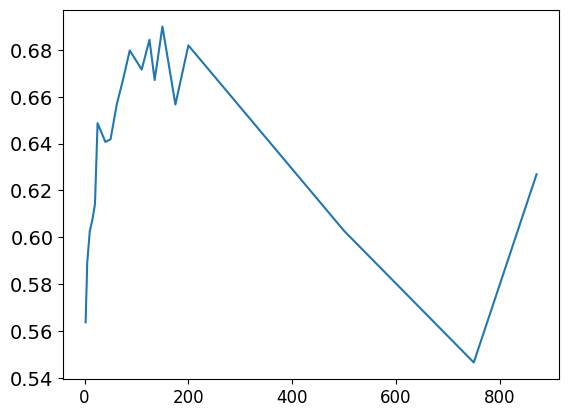

In [ ]:
plt.plot(n_components_list, acc_res)
plt.show()


In [ ]:

# iris = datasets.load_iris()
# parameters = {'alpha':[10**-3, 10**-2, 10**-1, 1, 5]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(iris.data, iris.target)
# sorted(clf.cv_results_.keys())

## LogisticRegression

C:\Users\33781\AppData\Local\Temp\ipykernel_26080\1871163530.py:25: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = np.arctanh(all_networks)


0.7272727272727273
0.004


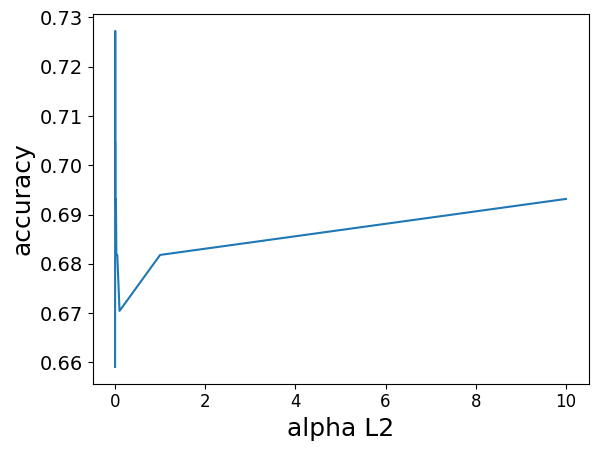

In [ ]:
n_components = 200
alphas = np.array([0.001,0.004, 0.005,0.006, 0.009, 0.01, 0.02, 0.03, 0.05, 0.1,1., 10.]  )# 2* np.logspace(-3,3, 100) #np.logspace(-3,5)[0.01,0.1, 1, 10, 50, 100, 200, 300, 500, 750, 1000, 1250, 1500]
acc_res = []
subject_IDs = Reader.get_ids()
labels = Reader.get_subject_score(subject_IDs, score="DX_GROUP")
x_data = get_networks(n_components, subject_IDs, kind="correlation", atlas_name="ho", variable="connectivity")
num_classes = 2
num_nodes = len(subject_IDs)

# Initialise variables for class labels and acquisition site
y_data = np.zeros([num_nodes, num_classes])
y = np.zeros([num_nodes, 1])

# x_data = feature_selection(x_data, y, train_ind, 150)

# Get acquisition site
site = Reader.get_subject_score(subject_IDs, score="SITE_ID")
unique = np.unique(list(site.values())).tolist()
for alpha in alphas:
    # G et class labels and acquisition site for all subjects
    for i in range(num_nodes):
        y_data[i, int(labels[subject_IDs[i]]) - 1] = 1
        y[i] = int(labels[subject_IDs[i]])
        site[i] = unique.index(site[subject_IDs[i]])


    skf = StratifiedKFold(n_splits=10, shuffle=True)#, random_state=123)
    # skf = KFold(n_splits=10)
    skf = StratifiedKFold(n_splits=10)
    for train_ind, test_ind in reversed(list(skf.split(np.zeros(num_nodes), np.squeeze(y)))):
        lin_acc_list = []
        # Linear classifier
        clf = LogisticRegression(C=alpha)#, solver='saga', penalty='elasticnet', l1_ratio=0.1)
        clf.fit(x_data[train_ind,:], y[train_ind].ravel())
        # Compute the accuracy
        lin_acc = clf.score(x_data[test_ind, :], y[test_ind].ravel())
        # Compute the AUC
        pred = clf.decision_function(x_data[test_ind, :])
        # lin_auc = sklearn.metrics.roc_auc_score(y[test_ind] - 1, pred)
        # lin_auc = sklearn.metrics.roc_auc_score(y[test_ind] - 1, pred)
        lin_acc_list.append(lin_acc)

    acc_res.append(np.array(lin_acc_list).mean())


print(np.array(acc_res).max())
print(alphas[np.array(acc_res).argmax()])
plt.figure()
plt.plot(alphas, acc_res)
plt.xlabel("alpha L2")
plt.ylabel("accuracy")
plt.show()


### SVC

C:\Users\33781\AppData\Local\Temp\ipykernel_26080\1871163530.py:25: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = np.arctanh(all_networks)
c:\Users\33781\miniconda3\envs\gda_pop_gcn\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\33781\miniconda3\envs\gda_pop_gcn\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\33781\miniconda3\envs\gda_pop_gcn\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\33781\miniconda3\envs\gda_pop_gcn\lib\site-packages\sklearn\svm\_cl

0.6818181818181818
0.001


c:\Users\33781\miniconda3\envs\gda_pop_gcn\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


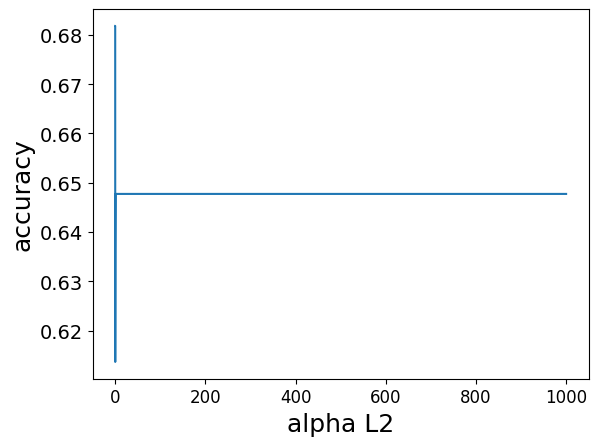

In [ ]:
n_components = 800
alphas = np.array([0.001,0.01, 0.1,0.5,1., 2,3,4, 10., 100, 500, 1000]  )# 2* np.logspace(-3,3, 100) #np.logspace(-3,5)[0.01,0.1, 1, 10, 50, 100, 200, 300, 500, 750, 1000, 1250, 1500]
acc_res = []
subject_IDs = Reader.get_ids()
labels = Reader.get_subject_score(subject_IDs, score="DX_GROUP")
x_data = get_networks(n_components, subject_IDs, kind="correlation", atlas_name="ho", variable="connectivity")
num_classes = 2
num_nodes = len(subject_IDs)

# Initialise variables for class labels and acquisition site
y_data = np.zeros([num_nodes, num_classes])
y = np.zeros([num_nodes, 1])

# x_data = feature_selection(x_data, y, train_ind, 70)

# Get acquisition site
site = Reader.get_subject_score(subject_IDs, score="SITE_ID")
unique = np.unique(list(site.values())).tolist()
for alpha in alphas:
    # G et class labels and acquisition site for all subjects
    for i in range(num_nodes):
        y_data[i, int(labels[subject_IDs[i]]) - 1] = 1
        y[i] = int(labels[subject_IDs[i]])
        site[i] = unique.index(site[subject_IDs[i]])


    skf = StratifiedKFold(n_splits=10, shuffle=True)#, random_state=123)
    # skf = KFold(n_splits=10)
    skf = StratifiedKFold(n_splits=10)
    for train_ind, test_ind in reversed(list(skf.split(np.zeros(num_nodes), np.squeeze(y)))):
        lin_acc_list = []
        # Linear classifier
        clf = LinearSVC(C=alpha)
        # clf = SVC(kernel='rbf', C=alpha)
        clf.fit(x_data[train_ind,:], y[train_ind].ravel())
        # Compute the accuracy
        lin_acc = clf.score(x_data[test_ind, :], y[test_ind].ravel())
        # Compute the AUC
        pred = clf.decision_function(x_data[test_ind, :])
        # lin_auc = sklearn.metrics.roc_auc_score(y[test_ind] - 1, pred)
        # lin_auc = sklearn.metrics.roc_auc_score(y[test_ind] - 1, pred)
        lin_acc_list.append(lin_acc)

    acc_res.append(np.array(lin_acc_list).mean())


print(np.array(acc_res).max())
print(alphas[np.array(acc_res).argmax()])
plt.figure()
plt.plot(alphas, acc_res)
plt.xlabel("alpha L2")
plt.ylabel("accuracy")
plt.show()


## RandomForestClassifier

In [ ]:

acc_res = []
x_data, y, num_nodes = rclass.get_x_data()
n_estimators_list = [50, 100, 150, 200, 300, 400, 500, 600, 700, 1000]
for n_estimators in n_estimators_list:
    print("n_estimators: ", n_estimators)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    # skf = KFold(n_splits=10)
    skf = StratifiedKFold(n_splits=10)
    lin_acc_list = []
    for train_ind, test_ind in reversed(list(skf.split(np.zeros(num_nodes), np.squeeze(y)))):

        # Linear classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=5)
        clf.fit(x_data[train_ind,:], y[train_ind].ravel())
        # Compute the accuracy
        lin_acc = clf.score(x_data[test_ind, :], y[test_ind].ravel())
        # Compute the AUC
        # pred = clf.decision_function(x_data[test_ind, :])
        # lin_auc = sklearn.metrics.roc_auc_score(y[test_ind] - 1, pred)
        # lin_auc = sklearn.metrics.roc_auc_score(y[test_ind] - 1, pred)
        lin_acc_list.append(lin_acc)
        # y_pred = clf.predict(x_data[test_ind, :])
        # accuracy = accuracy_score(y[test_ind], y_pred)
        # print(f"Accuracy: {accuracy * 100:.2f}%")

    acc_res.append(np.array(lin_acc_list).mean())


# # Create a Random Forest Classifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# # Train the model
# rf_model.fit(X_train, y_train)
# # Make predictions on the test set
# y_pred = rf_model.predict(X_test)
# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

print(np.array(acc_res).max())
print(n_estimators_list[np.array(acc_res).argmax()])
plt.figure()
plt.plot(n_estimators_list, acc_res)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()

n_estimators:  50


0.6016588296760711
200


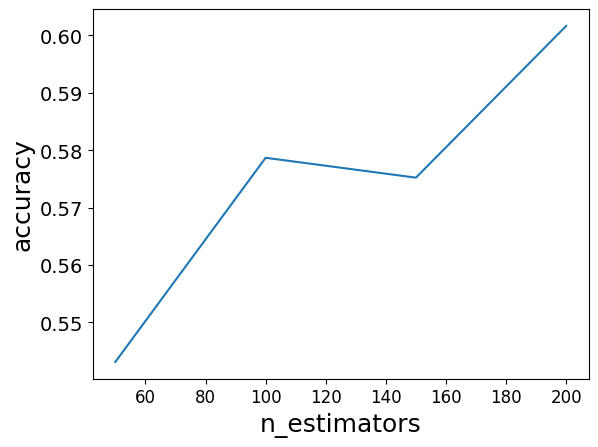

In [ ]:
print(np.array(acc_res).max())
print(n_estimators_list[np.array(acc_res).argmax()])
plt.figure()
plt.plot(n_estimators_list, acc_res)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()